In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import os

if os.path.isdir("../notebooks/"):
    os.chdir("..")

In [75]:
import json

import numpy as np
import matplotlib.pyplot as plt
import gensim.models as gm
from tqdm import tqdm

from badseeds import seedbank, utils

In [76]:
# path to config json file containing paths to datasets. change if necessary
CONFIG_PATH = "./config.json"

In [77]:
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

## Models and Data

### Models

In [50]:
embeddings_dir = os.path.join(
    config["models"]["dir_path"], config["models"]["nyt_subpath"]["0"]
)

In [51]:
models = []
for file in tqdm(os.listdir(embeddings_dir)):
    if file.endswith(".kv"):
        models.append(gm.KeyedVectors.load(os.path.join(embeddings_dir, file)))

100%|██████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.83it/s]


### Data

#### Gathered Seeds

In [88]:
seeds = seedbank.seedbanking(config["seeds"]["dir_path"] + "seeds.json")

In [72]:
seeds["Used in Paper"].isin(
    [
        "Semantics derived automatically from language corpora contain human-like biases (Caliskan et al., 2017)"
    ]
)

0       True
1       True
2       True
3       True
4       True
       ...  
173    False
174    False
175    False
176    False
177    False
Name: Used in Paper, Length: 178, dtype: bool

In [92]:
gathered_seeds = seedbank.get_seeds(
    seeds, seeds["Seeds ID"].tolist(), id_loc="Seeds ID"
)

#### Generated Seeds

currently using mock dataimport random

In [27]:
from urllib.request import Request, urlopen
import random

url = "https://svnweb.freebsd.org/csrg/share/dict/words?revision=61569&view=co"
req = Request(url, headers={"User-Agent": "Mozilla/5.0"})

web_byte = urlopen(req).read()

webpage = web_byte.decode("utf-8")

In [28]:
generated_seeds = random.choices(webpage.split("\n"), k=1000)

## Processing

In [29]:
gathered_seeds_embeddings = [
    utils.get_embeddings(seed_set, models, query_strat="average")
    for seed_set in gathered_seeds
]

In [43]:
len(gathered_seeds_embeddings)

178

In [44]:
seeds

,Category,Seeds,Source / Justification,Source Categories,Used in Paper,Link
Seeds ID,,,,,,
adjectives_appearance-Garg_et_al_2018,adjectives appearance,"['alluring', 'voluptuous', 'blushing', 'homely...","""mostly from"" http://usefulenglish.ru/vocabula...",other,Word Embeddings Quantify 100 Years of Gender a...,https://github.com/nikhgarg/EmbeddingDynamicSt...
adjectives_intelligence-Garg_et_al_2018,adjectives intelligence,"['precocious', 'resourceful', 'inquisitive', '...",mostly from https://www.e-education.psu.edu/wr...,other,Word Embeddings Quantify 100 Years of Gender a...,https://github.com/nikhgarg/EmbeddingDynamicSt...
adjectives_otherization-Garg_et_al_2018,adjectives otherization,"['devious', 'bizarre', 'venomous', 'erratic', ...",part of a list mostly from Gunkel (1987) (pers...,borrowed-from-social-sciences,Word Embeddings Quantify 100 Years of Gender a...,https://github.com/nikhgarg/EmbeddingDynamicSt...
adjectives_princeton-Garg_et_al_2018,adjectives princeton,"['brilliant', 'intelligent', 'honest', 'alert'...",part of a list mostly from Gunkel (1987) (pers...,borrowed-from-social-sciences,Word Embeddings Quantify 100 Years of Gender a...,https://github.com/nikhgarg/EmbeddingDynamicSt...
adjectives_sensitive-Garg_et_al_2018,adjectives sensitive,"['inhibited', 'complacent', 'sensitive', 'mell...",part of a list mostly from Gunkel (1987) (pers...,borrowed-from-social-sciences,Word Embeddings Quantify 100 Years of Gender a...,https://github.com/nikhgarg/EmbeddingDynamicSt...
...,...,...,...,...,...,...
white-Rudinger_et_al_2017,white,"['white', 'white_person', 'white_man', 'white_...",The U.S. Equal Employment Opportunity Commissi...,corpus-derived,Social Bias in Elicited Natural Language Infer...,https://github.com/cjmay/snli-ethics
white_collar_job-Fast_et_al_2016,white collar job,"['detective', 'executive', 'scientist', 'biolo...","""...to generate Empath’s category names and se...","crowd-sourced, curated, lexical-resources",Empath: Understanding Topic Signals in Large-S...,https://github.com/Ejhfast/empath-client
white_names-Knoche_et_al_2019,white names,"['adam', 'chip', 'harry', 'josh', 'roger', 'al...",We combined and extended sets which were previ...,"borrowed-from-social-sciences, prior-work",Identifying Biases in Politically Biased Wikis...,https://github.com/MKnoche/wiki_bias_embedding


In [40]:
# gathered_pca_models = [metrics.do_pca

generated_seeds["set_sim"] = comp_set_sim(generated_seeds["seeds"], "generated")

In [71]:
# linear fit of generated seed data
gen_coef = np.polyfit(generated_seeds["set_sim"], generated_seeds["exp_var"], 1)
gen_poly1d_fn = np.poly1d(gen_coef)

## Plotting

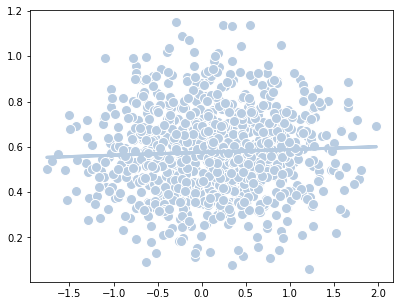

In [69]:
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(w=6.50127, h=5)

ax.plot(
    generated_seeds["set_sim"],
    generated_seeds["exp_var"],
    "o",
    generated_seeds["set_sim"],
    gen_poly1d_fn(generated_seeds["set_sim"]),
    color="#B8CCE1",
    linewidth=3,
    markersize=10,
    markerfacecolor="#B8CCE1",
    markeredgecolor="white",
)

plt.show()